# Example of global pipeline using SCDB dataset

Using a yoloV8 model that has been trained to recognize biomarkers on images. 

Link to the SCDB dataset: [https://github.com/adriano-lucieri/SCDB](https://github.com/adriano-lucieri/SCDB)

In [1]:
from ultralytics import YOLO
import torch

from torchvision.io import read_image, ImageReadMode
from torchvision import transforms

from ontoclassifier import *

import owlready2


## Loading ontology

In [2]:
onto_filename = "data/scdb.xml"
onto = owlready2.get_ontology(onto_filename).load()

## Global pipeline with Yolov8 Wrapper

In [3]:
target_classes = [onto.C1, onto.C2]

# or use all descendants of a class:
# target_classes = list(onto.Lesion.descendants())

In [4]:
# Load YOLO model detecting biomarkers
yolo_model = YOLO('data/scdb-yolov8.pt')
yolo_model.names

{0: 'Cross',
 1: 'Ellipse',
 2: 'Hexagon',
 3: 'Line',
 4: 'Pentagon',
 5: 'Rectangle',
 6: 'Star',
 7: 'Starmarker',
 8: 'Triangle',
 9: 'Tripod'}

In [5]:
hasConcept_feature = OntoFeature(onto.hasConcept) 
hasConcept_property_wrapper = YoloV8PropertyWrapper(yolo_model, 
                                                    hasConcept_feature, 
                                                    yolo_model.names)

fe_yolo = Yolov8FeaturesExtractor([ hasConcept_property_wrapper ])

ontological_extractor = OntologicalExtractor([fe_yolo])

onto_classifier = OntoClassifier(onto, target_classes, ontological_extractor)

pipeline = torch.nn.Sequential(
        ontological_extractor,
        onto_classifier
)

explainer = OntologicalExtractorExplainer(ontological_extractor, onto_classifier)

## Dataset

In [6]:
images = ['data/scdb-000000.png', 'data/scdb-000017.png']

YOLO_IMG_SIZE = (640, 640)

img_tensors = []
for img in images:
    img_tensors.append(transforms.Resize(YOLO_IMG_SIZE, antialias=False)(read_image(img, ImageReadMode.RGB).float()))

inputs = torch.stack(img_tensors)

## Predict and explain

In [7]:
preds = pipeline(inputs).to(torch.uint8)

In [8]:
encoder = onto_classifier.getTargettedClassesEncoder()
encoder.inverse_transform(preds)

[('https://www.univ-littoral.fr/lisic/sysreic/scdb.xml#C1',),
 ('https://www.univ-littoral.fr/lisic/sysreic/scdb.xml#C2',)]

This is a C1 because : 
  This is a C1_b because : 
    hasConcept SOME Ellipse is True 
      found Ellipse
    hasConcept SOME Star is True 
      found Star



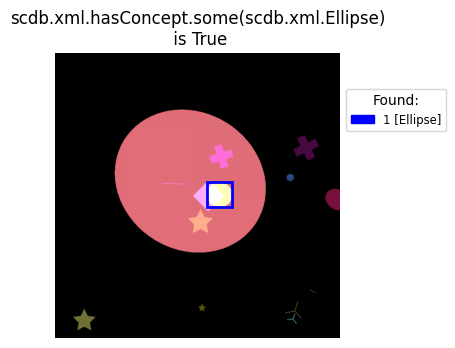

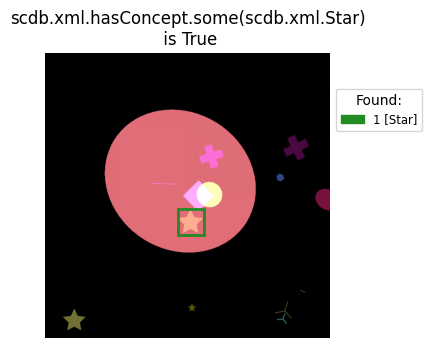

In [9]:
explainer.explain(
    onto.C1, 
    torch.stack([inputs[0]]))